# Extracting explanations from a sparse audio classifier

In [1]:
from audIBle.nn.autoencoders import SpecAE
from audIBle.nn.sparse_classif import SparseClassifier, SparseAEClassifier
from audIBle.data.datasets import UrbanSound8k

import torch
import numpy as np
import json
import os

In [ ]:
config_ids = [f"00{i}" for i in range(1,7)]
seed=42

conf_id = "006"
exp_name = f"{conf_id}_asae_classif_urbasound8k_{seed}"
exp_root = os.path.join(os.environ["EXP_ROOT"], "train/SAE/sparse_classif/",exp_name)

with open(os.path.join(exp_root, "config.json"), 'r') as fh:
    cfg = json.load(fh)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

state_dict_pth = os.path.join(cfg["model"]["asae_exp_path"], "best_model.pth")
state_dict = torch.load(state_dict_pth, map_location=device)
asae_cfg = os.path.join(cfg["model"]["asae_exp_path"], "config.json")
with open(asae_cfg, "r") as fh:
    asae_cfg = json.load(fh)

autoencoder = SpecAE(**asae_cfg["model"]) 
autoencoder.load_state_dict(state_dict=state_dict)

classif_params = cfg["model"]["classifier"]
classif_params["autoencoder"] = autoencoder
model = SparseAEClassifier(**classif_params)

/tmp/ipykernel_1938413/1704705930.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_pth, map_location=device)


In [4]:
# classifier checkpoint
classif_ckpt_path = os.path.join(exp_root,"best_model.pth")
ckpt = torch.load(classif_ckpt_path, map_location=device, weights_only=True)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [5]:
data_root = "/lium/corpus/vrac/audio_tagging/urbansound8k/urbansound8k"
fold_test = 10
dataset = UrbanSound8k(csv_path=os.path.join(data_root, "metadata/UrbanSound8K.csv"),
                           audio_dir=os.path.join(data_root, "audio"),
                           sample_rate=cfg["sample_rate"],
                           folds_to_use=[10],)

In [6]:
def extract_explanation(model, tau, input_data, label, device, spec_scale="log"):
    model.to(device)

    # retrieve the phase of the audio to reconstruct the explanation in the audio domain
    _, phase = model.get_stft(input_data)

    # extract all of the representations
    all_rep = model.forward_return_all(input_data.to(device))
    # pooled sparse representation (used to make the decision)
    Z = all_rep["sparse_latent_pooled"]
    Z_seq = all_rep["ae_hidden"].transpose(1,2)
    attention_weights = all_rep["attention_weights"].transpose(1,2)
    spec = all_rep["spec"]

    # print(f"{Z.shape=}\n{Z_seq.shape=}\n{spec.shape=}\n{attention_weights.shape=}")
    # weights of the linear classification head
    W_c = model.classif_head.weight

    # predicted class 
    pred = torch.argmax(torch.nn.functional.softmax(all_rep["logits"], dim=-1),dim=-1)
    n_classes = W_c.shape[0]
    
    explain = {"model_outputs": all_rep, "explain": {}}

    for c in range(n_classes):
        # select the weights of the classification layer according to class c
        w_class = W_c[c,:]
        # compute class relevance based on classification head weights
        #TODO check the formula w.r.t. the JSALT code
        r_c = w_class * Z
        r_c = r_c / r_c.abs().max() 
        # binarize based on a threshold
        mask = r_c > tau

        # mask the latent representation according to the relevant dimensions
        Z_seq_mask = Z_seq * mask.unsqueeze(-1)
        # print(f"{Z_seq_mask.shape=}")
        # decode the latent space of the SAE after selecting the relevant dimensions 
        spec_dec_mask = model.audio_ae.decode(Z_seq_mask)
        # print(f"{spec_dec_mask.shape=}")
        
        ### --- First way of extracting explanation ---
        ### The output of the SAE is used to create a soft mask over its input. The soft-masked version of the SAE input is then decoded using the decoder of the audio AE. 
        # soft mask for explanation extraction
        # print(f"{sae_dec_mask.sum(dim=-1, keepdim=True).shape=}")
        soft_mask = spec_dec_mask / spec_dec_mask.sum(dim=-2, keepdim=True)

        # masked latent representation for explanation extraction
        spec_soft_mask = soft_mask * spec

        # print(f"{attention_weights.shape=}")
        spec_soft_mask_att = spec_soft_mask * attention_weights

        ### --- Second way of extracting explanations ---
        ### The latent space of the SAE is masked according to the relevant components. This masked latent is decoded using SAE decoder, and then the audio AE decoder.
        spec_dec_mask_att = spec_dec_mask * attention_weights

        explain["explain"][f"class_{c}"] = {"relevance": r_c, 
                                 "bin_relevance": mask, 
                                 "explanation_V1": spec_soft_mask,
                                 "explanation_V2": spec_dec_mask,
                                 "explanation_att_V1": spec_soft_mask_att,
                                 "explanation_att_V2": spec_dec_mask_att,
                                 "label": label, 
                                 "pred": pred,
                                 "spec_phase": phase}
    return explain

### Extract explanations for each test example

In [ ]:
model.to(device)
tau = 0.2
overwrite = False
import tqdm

from torch.utils.data import DataLoader
import pickle 

test_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
classes = dataset.classes
all_feat = {}
for i in range(len(classes)):
    all_feat[f"class_{i}"] = []

if os.path.exists(f"explain_{conf_id}.pkl") and not overwrite:
    with open(f"explain_{conf_id}.pkl", 'rb') as fh:
        all_feat = pickle.load(fh)
else:
    for i_data, (wav, label) in tqdm.tqdm(enumerate(test_loader),desc="extract explanation"):
        #wav, label = dataset[i_data]
        #wav = wav.unsqueeze(0)
        label = label.squeeze()
        explain = extract_explanation(model, tau, wav, label, device)
        model_outputs = explain["model_outputs"]   

        pred_class = explain["explain"][f"class_{label}"]["pred"]
        pred_class = pred_class.item()
        latent = model_outputs["ae_hidden"]
        attention_weights = model_outputs["attention_weights"]
        spec_orig = model_outputs["spec"]
        relevance = explain["explain"][f"class_{label}"]["relevance"]
        
        explain_dict = {"pred_lass": pred_class, "latent": latent, "attention_weights": attention_weights, 'relevance': relevance, "spec_orig": spec_orig}

        all_feat[f"class_{label}"].append(explain_dict)

    with open(f"explain_{conf_id}.pkl", 'wb') as fh:
        pickle.dump(all_feat,fh)

### Plot the distribution of activated sparse dimensions per class

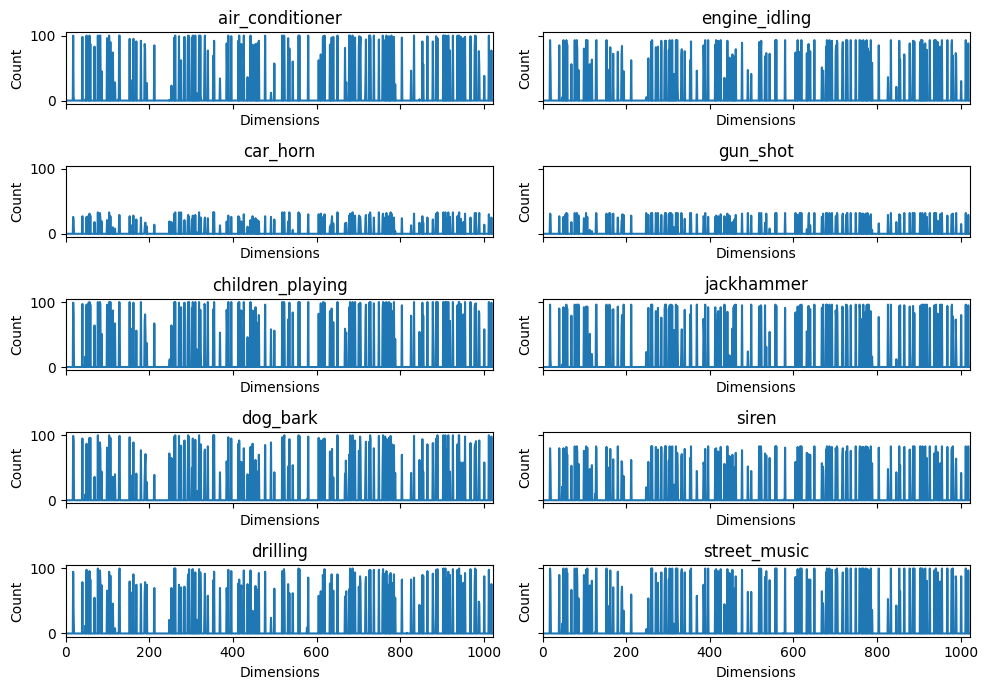

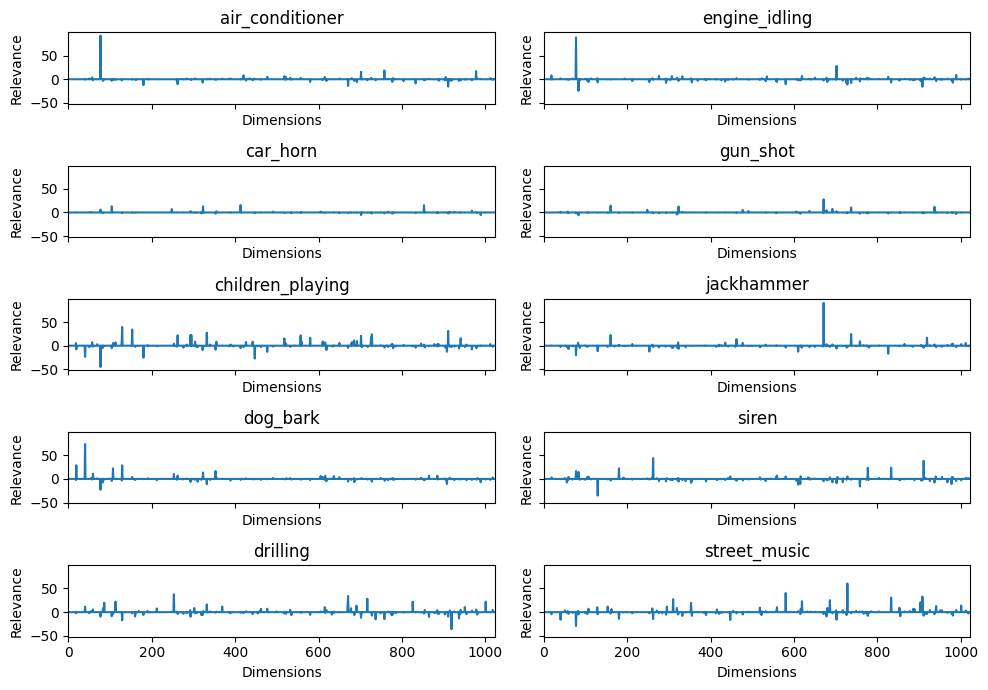

In [10]:
import matplotlib.pyplot as plt
z_dim = 1024

f, axs = plt.subplots(5,2,figsize=(10,7),layout='tight', sharex=True, sharey=True)
f, ax2s = plt.subplots(5,2,figsize=(10,7),layout='tight', sharex=True, sharey=True)
jp = 0
ip = 0
for c in range(len(classes)):

    feat_for_class = all_feat[f"class_{c}"]

    n_ex = len(feat_for_class)

    class_relevance = np.zeros(z_dim)
    class_dim_count = np.zeros(z_dim)
    for ii, ex in enumerate(feat_for_class):
        rel = ex["relevance"].detach().squeeze().cpu().numpy()
        class_relevance += rel
        z = ex["latent"].detach().squeeze().cpu().numpy()
        z_active = (np.sum(z,axis=0) > 0).astype(int)
        class_dim_count += z_active
    
    ax = axs[ip,jp]
    ax.plot(class_dim_count)
    ax.set_xlim((0,z_dim-1))
    ax.set_xlabel('Dimensions')
    ax.set_ylabel('Count')
    ax.set_title(f"{classes[c]}")

    ax = ax2s[ip,jp]
    ax.plot(class_relevance)
    ax.set_xlim((0,z_dim-1))
    ax.set_xlabel('Dimensions')
    ax.set_ylabel('Relevance')
    ax.set_title(f"{classes[c]}")

    ip+=1

    if c==4:
        jp=1
        ip=0



plt.show()


### Visualize the sparse sequence (before pooling) for a few examples

In [ ]:
import matplotlib.pyplot as plt

def plot_explain_spec(x_orig, x_hat, x_explain1, code_seq, attention_weights=None, relevance=None, **plt_kw):
    sr = plt_kw.get("samplerate", 22050)
    class_id = plt_kw.get("class_id", "")
    fig, axs = plt.subplots(3, 1, figsize=(7, 10), sharex=True, layout="tight")
    title_info = plt_kw.get("title", "")
    # Plot original and explanation spectrograms
    for ax, spec, title in zip(
        axs[:3], [x_orig, x_hat, x_explain1], [f"Original", f"Reconstructed", f"Explanation"]
    ):
        # assume input is torch.Tensor or np.ndarray, shape (1, freq, time) or (freq, time)
        if hasattr(spec, "detach"):
            spec = spec.detach().cpu().squeeze().numpy()
        else:
            spec = np.squeeze(spec)

        title  = title + title_info
        ax.set_title(title)
        # Set y-axis in Hz

        im = ax.imshow(
            spec,
            aspect="auto",
            origin="lower",
            cmap="magma",
            interpolation="nearest",
        )
        n_freq = spec.shape[0]
        y_ticks = np.linspace(0, n_freq - 1, 6)
        y_labels = np.linspace(0, sr // 2, 6, dtype=int)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels)
        ax.set_ylabel("Frequency (Hz)")
        # Set x-axis in seconds
        n_time = spec.shape[1]
        x_ticks = np.linspace(0, n_time - 1, 6)
        x_labels = np.round(np.linspace(0, n_time / sr, 6), 2)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        # Place colorbar on top
        cbar = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.2)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')
    axs[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

    fig2, axs = plt.subplots(2, 2, figsize=(9, 7), layout="tight")
    ax = axs[0,0]
    if hasattr(code_seq, "detach"):
        codes = code_seq.detach().cpu().squeeze().numpy()
    else:
        codes = np.squeeze(code_seq)

    im = ax.imshow(
        codes,
        aspect="auto",
        origin="lower",
        cmap="magma",
        interpolation="nearest",
    )
    print(f"{codes.shape=}")
    n_dim = codes.shape[0]
    y_ticks = np.linspace(0, n_dim - 1, 4)
    y_labels = np.linspace(1, n_dim, 4, dtype=int)  # indexes from 1 to 1024
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel("Dimension index")
    # Set x-axis in seconds
    n_time = code_seq.shape[-1]
    x_ticks = np.linspace(0, n_time - 1, 6)
    x_labels = np.round(np.linspace(0, n_time / sr, 6), 2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_title("Sparse latent space (Z)")
    # Place colorbar on top
    # cbar = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.2)
    # cbar.ax.xaxis.set_ticks_position('top')
    # cbar.ax.xaxis.set_label_position('top')

    # Plot attention weights
    ax = axs[1,0]
    if hasattr(attention_weights, "detach"):
        attn = attention_weights.detach().cpu().squeeze().numpy()
    else:
        attn = np.squeeze(attention_weights)

    # attn shape: (time,) or (1, time)
    ax.plot(attn, color="tab:blue")
    ax.set_ylabel("Attention weight")
    ax.set_xlabel("Time (s)")
    ax.set_title("Attentive pooling weights")
    ax.set_ylim(0, np.max(attn) * 1.1)
    n_time = attn.shape[-1]
    x_ticks = np.linspace(0, n_time - 1, 6)
    x_labels = np.round(np.linspace(0, n_time / sr, 6), 2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    # Align attention x-axis with spectrograms
    ax.set_xlim(axs[0,0].get_xlim())
    ax.grid()

    ax = axs[0,1]
    if hasattr(relevance, "detach"):
        rel = relevance.detach().cpu().squeeze().numpy()
    else:
        rel = np.squeeze(relevance)
    n_freq = rel.shape[0]
    # x_ticks = np.linspace(0, n_freq - 1, 6)
    # x_labels = np.linspace(0, sr // 2, 6, dtype=int)
    x_ticks = np.linspace(0, n_dim - 1, 4)
    x_labels = np.linspace(1, n_dim, 4, dtype=int)  # indexes from 1 to 1024

    ax.plot(rel, np.arange(n_freq))
    ax.set_yticks(x_ticks)
    ax.set_yticklabels(x_labels)
    ax.set_ylim(axs[0,0].get_ylim())
    ax.set_xlim([-1,1])
    # ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Relevance")
    ax.set_title("Component relevance")

    plt.show()



def get_stft_param(cfg, add_pad=False):
    n_fft = cfg["model"]["autoencoder"]["n_fft"]
    hop_length = cfg["model"]["autoencoder"]["hop_length"]
    win_length = cfg["model"]["autoencoder"]["win_length"]
    if add_pad:
        pad = cfg["model"]["autoencoder"]["pad"]
        center = cfg["model"]["autoencoder"]["center"]
    if add_pad:
        return {"n_fft": n_fft, "hop_length": hop_length, "win_length": win_length, "pad": pad, "center": center}
    
    return {"n_fft": n_fft, "hop_length": hop_length, "win_length": win_length}


In [ ]:
model.to(device)
W_c = model.classif_head.weight
#W_sae_d = model.sae.decoder.weight
tau = 0.25

from torch.utils.data import DataLoader
import IPython.display as ipd

test_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
classes = dataset.classes
for i_data, (wav, label) in enumerate(test_loader):
    #wav, label = dataset[i_data]
    #wav = wav.unsqueeze(0)
    label = label.squeeze()
    # all_rep = model.forward_return_all(wav.to(device))

    # for k,v in all_rep.items():
    #     print(f"{k}: {v.shape}")
    
    
    explain = extract_explanation(model, tau, wav, label, device)
    model_outputs = explain["model_outputs"]   
    # for k in model_outputs.keys():
    #     print(k)

    pred_class = explain["explain"][f"class_{label}"]["pred"]
    pred_class = pred_class.item()
    
    spec_orig = model_outputs["spec"]
    code_seq = model_outputs["ae_hidden"]
    attention_weights = model_outputs["attention_weights"]
    relevance = explain["explain"][f"class_{pred_class}"]["relevance"]

    X1 = explain["explain"][f"class_{pred_class}"]["explanation_V2"]
    #X1 = model_outputs["spec_hat"]
    # X2 = explain["explain"][f"class_{pred_class}"]["explanation_V2"]

    plot_explain_spec(x_orig=spec_orig, 
                    x_hat=model_outputs["spec_hat"],
                    x_explain1=X1, 
                    code_seq=torch.log(code_seq.transpose(1,2)+1e-8), 
                    attention_weights=attention_weights, 
                    relevance=relevance,
                    samplerate = cfg["sample_rate"],
                    title=f"- target class={classes[label.item()]} - pred={classes[pred_class]}")
    
    # generate audio signals from explanations
    stft_param = model.audio_ae.get_stft_params()
    if stft_param["scale"] == "log":
        X1_lin = torch.exp(X1)
        # X2_lin = torch.exp(X2)
    phi = explain["explain"][f"class_{pred_class}"]["spec_phase"]

    stft1 = X1_lin * torch.exp(1j*phi)
    # stft2 = X2_lin * torch.exp(1j*np.pi*phi)
    x1 = torch.istft(stft1.squeeze(), n_fft=stft_param["n_fft"], win_length=stft_param["win_length"], hop_length=stft_param["hop_length"])
    # x2 = torch.istft(stft2.squeeze(), **stft_param)

    print("Original")
    ipd.display(ipd.Audio(wav.detach().cpu().squeeze().numpy(),rate=cfg["sample_rate"]))
    print("Explanation")
    ipd.display(ipd.Audio(x1.detach().cpu().squeeze().numpy(),rate=cfg["sample_rate"]))

    
    # if pred_class.item() != label.item():
    #     print("Wrong classification!")
    #     plot_explain_spec(x_orig=spec_orig, 
    #                 x_explain=explain["explain"][f"class_{pred_class.item()}"]["relevant_spec"], 
    #                 attention_weights=attention_weights, 
    #                 class_id="pouet", 
    #                 samplerate = cfg["sample_rate"],
    #                 title=f"- pred class={classes[pred_class.item()]} - target={classes[label.item()]}")
        

    if i_data >=10:
        break